In [1]:
import keras
import os
import datetime
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_dir = "database/train" 
test_dir = "database/test"   
img_size = 48 # Original pixel size of the image (48x48x1), only 1 channel since they're grayscale
classes = 7 # Number of emotions the model is able to classify

Let's now explore the dataset.

First by taking look at the data distribution of each class


In [3]:
def count_images_per_class(path, set):
    '''
    Counts the number of images in each class folders and returns a dataframe with the results.

    path: The path to the base folder containing the train and test sets.
    set: train or test, selects which dataset to analyse.
    '''
    
    class_dict = {}
    for emotion in os.listdir(path):
        class_dir = f"{path}/{emotion}"
        class_dict[emotion] = len(os.listdir(class_dir))
    df = pd.DataFrame(class_dict, index=[set])
    return df

train_count = count_images_per_class(train_dir, 'train')
test_count = count_images_per_class(test_dir, 'test')

print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


We can now visualize the number of images per class in a bar graph

In the train set:

<AxesSubplot:>

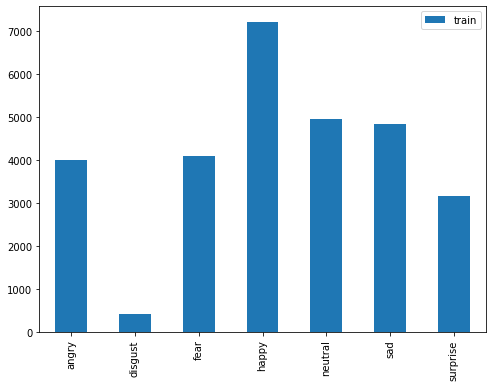

In [4]:
train_count.transpose().plot(kind='bar', figsize=(8, 6))

As well as the test set:

<AxesSubplot:>

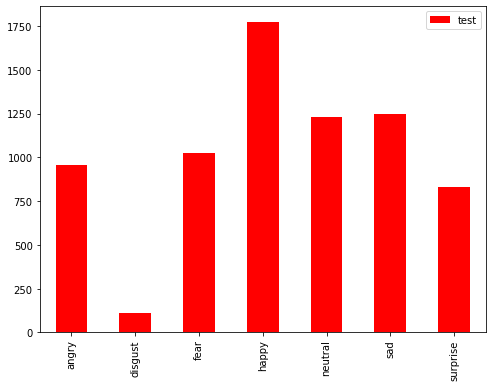

In [5]:
test_count.transpose().plot(kind='bar', figsize=(8, 6), color='red')

The distributions between the train and test sets are similar enough, but we have imbalanced classes, disgust in particular has very few entries.

Let's also take a look at some of the images:

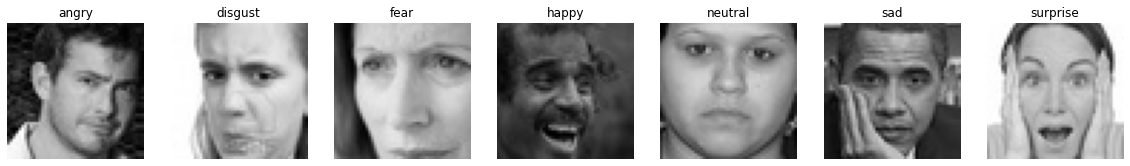

In [6]:
plt.figure(figsize=(20,30))
for i, emotion in enumerate(os.listdir(train_dir)):
    img = load_img((train_dir +'/'+ emotion +'/'+ os.listdir(train_dir + '/' + emotion)[1]))
    plt.subplot(1, 7, i+1)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')
plt.show()

Great, everything seems to be fine.

We can now perform the preprocessing steps.

We will need to use a generator to deal with class imbalance, this way the model wont be biased thinking disgust basically never occurs, for example.

We'll also normalize the images by dividing them by 255 (images have pixel values in the range of 0 to 255), 

Normalization is a data pre-processing tool used to bring the numerical data to a common scale without distorting its shape.
Having values closer to the range between 0 and 1 helps to stabilize and speed up the learning process due to the mathematical operations performed on them.

We are also able to generate random variations of each image, to complement the dataset, creating more data for the model. This helps to reduce bias as well.

And finaly, we create a validation dataset, by spliting the train dataset 80-20, to compare the training results with, this also reduces bias, as we're not trying to learn specifically how the classify the images on the train set, we want the model to be able to generalize to new faces.

In [7]:
"""
Data Augmentation
--------------------------
rotation_range = rotates the image with the amount of degrees we provide
width_shift_range = shifts the image randomly to the right or left along the width of the image
height_shift range = shifts image randomly to up or below along the height of the image
horizontal_flip = flips the image horizontally
rescale = to scale down the pizel values in our image between 0 and 1
zoom_range = applies random zoom to our object
validation_split = reserves some images to be used for validation purpose
"""

train_datagen = ImageDataGenerator(     rotation_range = 5,
                                        width_shift_range = 0.1,
                                        height_shift_range = 0.1,
                                        horizontal_flip = True,
                                        rescale = 1./255,
                                        zoom_range = 0.1,
                                        validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                        validation_split = 0.2)

In [8]:
"""
Applying data augmentation to the images as we read 
them from their respectivve directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size, img_size),
                                                    batch_size = 64,
                                                    shuffle=True,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                    )
validation_generator = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (img_size, img_size),
                                                              batch_size = 64,
                                                              shuffle=True,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                              )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


Let's take a look at a few examples of the pseudo-ramdomly generated images:

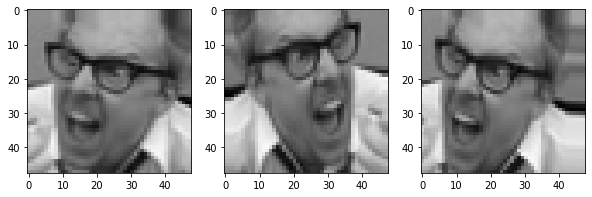

In [9]:
# Load an example image 
image_path = "database/train/angry/Training_3908.jpg"
img = keras.preprocessing.image.load_img(image_path, target_size= (img_size, img_size))
img_tensor = keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# We use the exact same datagenerator for the train images, execpt we don't normalize the images here, to be able to display them properly
datagen = ImageDataGenerator( rotation_range = 5,
                              width_shift_range = 0.1,
                              height_shift_range = 0.1,
                              horizontal_flip = True,
                              # rescale = 1./255,
                              zoom_range = 0.1,
                              validation_split = 0.2
                              )
                              
# Create our batch of one image and plot it
pic = datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(10,8))
for i in range(1,4):
  plt.subplot(1, 3, i)
  batch = pic.next()
  image_ = batch[0].astype('uint8')
  plt.imshow(image_)
plt.show()

Right, these should help the model generalize the patterns, instead of only remembering the exact pixel values that lead to each class.

We are now ready to build our models.

We are creating blocks using Conv2D layer, Batch-Normalization, Max-Pooling2D, Dropout, Flatten, and then stacking them together and at the end-use Dense Layer for output, you can read more on how to design CNN models. 

In [10]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [11]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

fernet = get_model((img_size, img_size, 1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

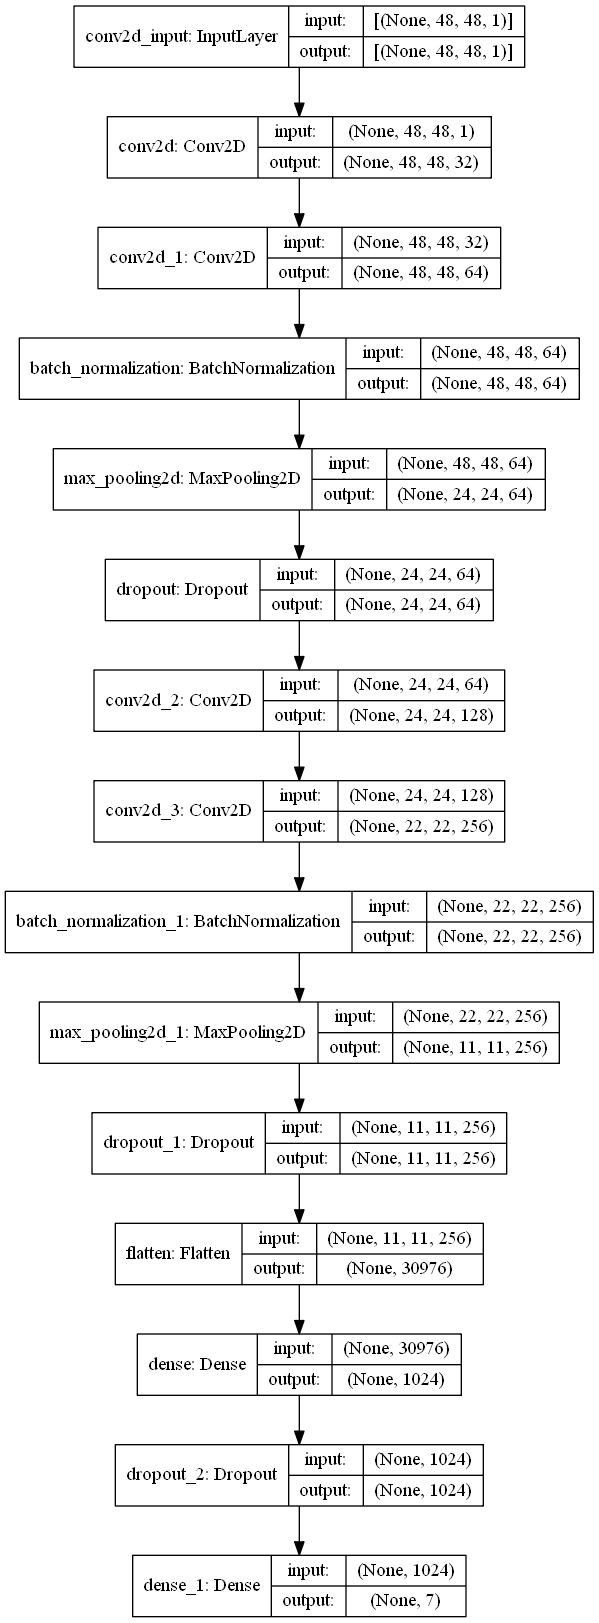

In [12]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

Let's create some callback functions to improve the model training

In [13]:
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Compiling model using Adam optimizer keeping lr= 0.001, if the model’s accuracy doesn’t improve after some epochs learning rate decreases by decay factor.

In [14]:
fernet.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

We are going to go through the whole dataset 60 times, with selecting 64 images per iteration.

In [15]:
epochs = 60
batch_size = 64

Now we can simply train the model

In [16]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

hist = fernet.fit(x=train_generator,
                validation_data=validation_generator,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                steps_per_epoch=steps_per_epoch,
                validation_steps=validation_steps)

Epoch 1/60
358/358 [==============================] - 55s 122ms/step - loss: 4.4062 - accuracy: 0.2543 - val_loss: 5.3101 - val_accuracy: 0.1662

Epoch 00001: val_loss improved from inf to 5.31007, saving model to ferNet.h5
Epoch 2/60
358/358 [==============================] - 18s 50ms/step - loss: 3.6378 - accuracy: 0.3036 - val_loss: 3.3159 - val_accuracy: 0.3587

Epoch 00002: val_loss improved from 5.31007 to 3.31586, saving model to ferNet.h5
Epoch 3/60
358/358 [==============================] - 18s 50ms/step - loss: 3.1850 - accuracy: 0.3330 - val_loss: 2.9085 - val_accuracy: 0.3800

Epoch 00003: val_loss improved from 3.31586 to 2.90853, saving model to ferNet.h5
Epoch 4/60
358/358 [==============================] - 18s 50ms/step - loss: 2.8048 - accuracy: 0.3596 - val_loss: 2.5384 - val_accuracy: 0.4233

Epoch 00004: val_loss improved from 2.90853 to 2.53842, saving model to ferNet.h5
Epoch 5/60
358/358 [==============================] - 18s 50ms/step - loss: 2.4916 - accuracy: 

Let's plot the accuracy and loss of the train and validation sets.

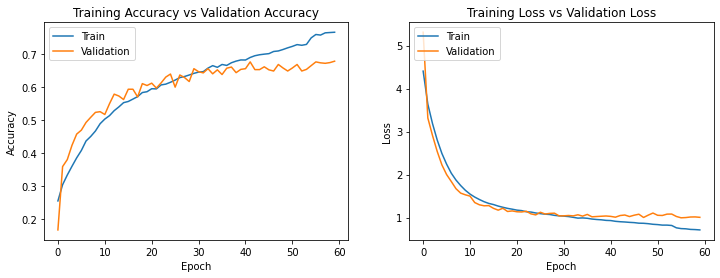

In [17]:
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

Let's do a sanity test, and check the results on a test image:

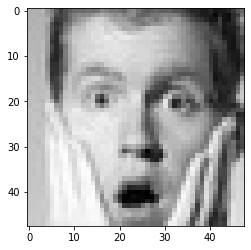

In [18]:
img = load_img("database/test/surprise/PrivateTest_54842414.jpg",target_size = (48,48), color_mode = "grayscale")
img = np.array(img)
plt.imshow(img, cmap='gray')

In [19]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}
img = np.expand_dims(img,axis = 0) # makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = fernet.predict(img)
result = list(result[0])
for i in range(len(result)):
    result[i] = f'{result[i]:.2f}'
print(label_dict)
print(result)
print(label_dict[np.argmax(result)])

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00']
Surprise


Great, as we can see, the model is 100% confident that this is a suprised face.

In [20]:
train_loss, train_acc = fernet.evaluate(train_generator)
test_loss, test_acc   = fernet.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 1s 31ms/step - loss: 1.0004 - accuracy: 0.6809
final train accuracy = 84.14 , validation accuracy = 68.09


We can save this weights.

In [21]:
fernet.save_weights('fernet_bestweight.h5')

Let's also plot the confusion matrix for the train datset. 

Confusion Matrix
[[ 432   38  404  835  543  550  394]
 [  46    3   40   99   64   58   39]
 [ 441   38  420  824  594  610  351]
 [ 765   80  716 1475 1052 1060  624]
 [ 460   67  492 1042  786  687  438]
 [ 495   47  505  996  721  705  395]
 [ 315   27  308  661  475  476  275]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.14      0.14      3196
     disgust       0.01      0.01      0.01       349
        fear       0.15      0.13      0.14      3278
       happy       0.25      0.26      0.25      5772
     neutral       0.19      0.20      0.19      3972
         sad       0.17      0.18      0.18      3864
    surprise       0.11      0.11      0.11      2537

    accuracy                           0.18     22968
   macro avg       0.15      0.15      0.14     22968
weighted avg       0.18      0.18      0.18     22968



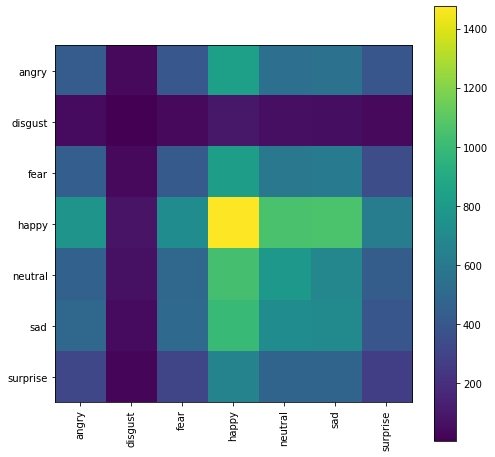

In [22]:
y_pred = fernet.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

And the test dataset

Confusion Matrix
[[25  0 20 53 39 30 24]
 [ 3  0  1  6  6  5  1]
 [36  1 21 49 43 30 24]
 [62  6 27 78 82 61 38]
 [35  2 34 58 54 37 26]
 [37  1 29 65 43 43 31]
 [31  1 18 42 34 29 11]]
Classification Report
              precision    recall  f1-score   support

       angry       0.11      0.13      0.12       191
     disgust       0.00      0.00      0.00        22
        fear       0.14      0.10      0.12       204
       happy       0.22      0.22      0.22       354
     neutral       0.18      0.22      0.20       246
         sad       0.18      0.17      0.18       249
    surprise       0.07      0.07      0.07       166

    accuracy                           0.16      1432
   macro avg       0.13      0.13      0.13      1432
weighted avg       0.16      0.16      0.16      1432



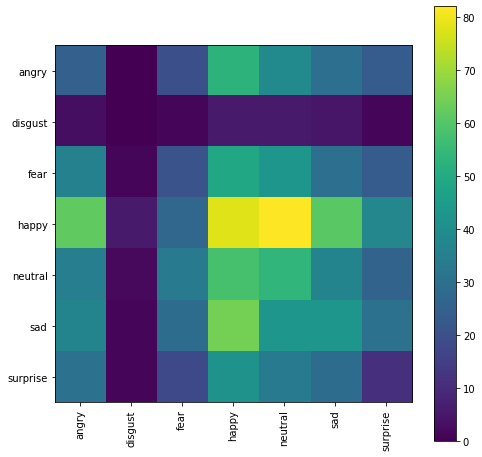

In [23]:
y_pred = fernet.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [24]:
if fernet is None and os.path.isfile(chk_path):
    fernet=load_model(chk_path)

Faces by usually are detected using OpenCV's Haar Cascade classifier, but we can use the more accurate MTCNN network as well:

In [25]:
detector = MTCNN()

In [26]:
cap = cv2.VideoCapture(0)
label_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('emotions.avi', fourcc, 4.0, (640,480))

while True: 
    # Capture frame-by-frame
    __, frame = cap.read()
    
    # Use MTCNN to detect faces
    result = detector.detect_faces(frame)
    if result != []:
        for person in result:
            bounding_box = person['box']
            keypoints = person['keypoints']
            ROI = frame[bounding_box[1]:bounding_box[1] + bounding_box[3], bounding_box[0]:bounding_box[0]+bounding_box[2]]
            ROI = cv2.resize(ROI, (img_size, img_size))
            ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)
            ROI = np.expand_dims(ROI, axis = 0) # makes image shape (1,48,48)
            ROI = ROI.reshape(1,img_size,img_size,1)
            ROI = ROI * 1/255

            result = fernet.predict(ROI)
            result = list(result[0])
            result = label_dict[np.argmax(result)]
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame, result, (bounding_box[0], bounding_box[1] - 15), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

            cv2.rectangle(frame,
                          (bounding_box[0], bounding_box[1]),
                          (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                          (0,155,255),
                          2)
    
            cv2.circle(frame,(keypoints['left_eye']), 2, (0,155,255), 1)
            cv2.circle(frame,(keypoints['right_eye']), 2, (0,155,255), 1)
            cv2.circle(frame,(keypoints['nose']), 2, (0,155,255), 1)
            cv2.circle(frame,(keypoints['mouth_left']), 2, (0,155,255), 1)
            cv2.circle(frame,(keypoints['mouth_right']), 2, (0,155,255), 1)
    # display resulting frame, close webcam when the Q key is pressed on the keyboard
    cv2.imshow('frame',frame)
    out.write(frame)
    if cv2.waitKey(1) &0xFF == ord('q'):
        break
# when everything's done, release capture
cap.release()
out.release()
cv2.destroyAllWindows()